# LiveBench Visualization

This notebook visualizes results from LiveBench runs.

In [ ]:
# Cell 1: Class Definitions & Imports
import os
import sys
import json
import glob
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from google.colab import drive
from IPython import get_ipython

class LiveBenchConfig:
    """Stores all configuration parameters for the LiveBench visualization."""
    def __init__(self,
                 gdrive_base_path: str,
                 model_ids_to_compare: list,
                 bench_name_for_vis: str,
                 livebench_release: str,
                 tasks_to_exclude: set = None
                 ):
        self.gdrive_base_path = gdrive_base_path
        self.model_ids_to_compare = model_ids_to_compare
        self.bench_name_for_vis = bench_name_for_vis
        self.livebench_release = livebench_release
        self.tasks_to_exclude = tasks_to_exclude if tasks_to_exclude is not None else set()

        # Derived Paths
        self.livebench_repo_path = os.path.join(self.gdrive_base_path, "LiveBench")
        self.livebench_subdir_path = os.path.join(self.livebench_repo_path, "livebench")
        self.plots_output_dir = os.path.join(self.gdrive_base_path, "plots")
        self.livebench_data_path = os.path.join(self.livebench_subdir_path, "data")
        self.groups_csv_path = os.path.join(self.livebench_subdir_path, "all_groups.csv")
        self.tasks_csv_path = os.path.join(self.livebench_subdir_path, "all_tasks.csv")

        print("--- Configuration Initialized ---")
        print(f"Google Drive Base Path: {self.gdrive_base_path}")
        print(f"LiveBench Repo Path: {self.livebench_repo_path}")
        print(f"LiveBench Subdir Path: {self.livebench_subdir_path}")
        print(f"Plots Output Dir: {self.plots_output_dir}")
        print(f"Models to Compare: {self.model_ids_to_compare}")
        print(f"Benchmark(s): {self.bench_name_for_vis}")
        print(f"LiveBench Release: {self.livebench_release}")
        print(f"Tasks to Exclude: {self.tasks_to_exclude}")
        print(f"Groups CSV Path: {self.groups_csv_path}")
        print(f"Tasks CSV Path: {self.tasks_csv_path}")
        print("---------------------------------")

    def get_model_list_str(self) -> str:
        """Returns a space-separated string of model IDs for command line usage."""
        return " ".join(self.model_ids_to_compare)

class LiveBenchSetup:
    """Handles environment setup tasks like mounting Drive, creating dirs, cloning repo."""
    def __init__(self, config: LiveBenchConfig):
        self.config = config
        self.ipython = get_ipython()

    def _run_shell_command(self, command):
        """Runs a shell command using IPython's ! syntax if available."""
        if self.ipython:
            print(f"Running: {command}")
            self.ipython.run_line_magic('sx', command) # Use sx to capture output/errors
        else:
            print(f"Cannot run shell command '{command}' without IPython.")

    def _change_directory(self, path):
        """Changes the current working directory."""
        print(f"Changing directory to: {path}")
        os.chdir(path)
        if self.ipython:
             self.ipython.run_line_magic('pwd', '')

    def mount_drive(self, force_remount=True):
        """Mounts Google Drive."""
        print("Mounting Google Drive...")
        try:
            drive.mount('/content/drive', force_remount=force_remount)
            print("Google Drive mounted successfully.")
        except Exception as e:
            print(f"Error mounting Google Drive: {e}")

    def create_directories(self):
        """Creates necessary directories based on config."""
        print("Creating necessary directories...")
        os.makedirs(self.config.gdrive_base_path, exist_ok=True)
        os.makedirs(self.config.plots_output_dir, exist_ok=True)
        print(f"Directory created/exists: {self.config.gdrive_base_path}")
        print(f"Directory created/exists: {self.config.plots_output_dir}")

    def clone_repository(self):
        """Clones the LiveBench repository if it doesn't exist."""
        self._change_directory(self.config.gdrive_base_path)
        if not os.path.exists(self.config.livebench_repo_path):
            print("Cloning LiveBench repository...")
            self._run_shell_command(f"git clone https://github.com/LiveBench/LiveBench.git {self.config.livebench_repo_path}")
        else:
            print("LiveBench repository already exists.")

    def install_dependencies(self):
        """Installs LiveBench dependencies using pip."""
        if os.path.exists(self.config.livebench_repo_path):
            self._change_directory(self.config.livebench_repo_path)
            print("Installing LiveBench dependencies...")
            self._run_shell_command("pip install -e .")
        else:
            print("ERROR: Cannot install dependencies, LiveBench repo path not found.")

class LiveBenchRunner:
    """Runs the LiveBench result generation script."""
    def __init__(self, config: LiveBenchConfig):
        self.config = config
        self.ipython = get_ipython()

    def generate_result_csvs(self) -> bool:
        """Generates the all_groups.csv and all_tasks.csv files."""
        print("\n--- Generating Combined CSV Result Files ---")
        if not self.config.model_ids_to_compare:
            print("ERROR: No models specified in config. Skipping CSV generation.")
            return False
        if not os.path.exists(self.config.livebench_subdir_path):
            print(f"ERROR: LiveBench subdirectory not found at {self.config.livebench_subdir_path}. Skipping CSV generation.")
            return False

        os.chdir(self.config.livebench_subdir_path)
        print(f"Current directory: {os.getcwd()}")

        model_list_str = self.config.get_model_list_str()
        command = (
            f"python show_livebench_result.py "
            f"--model-list {model_list_str} "
            f"--bench-name '{self.config.bench_name_for_vis}' " # Add quotes for multi-word bench names
            f"--livebench-release-option {self.config.livebench_release}"
        )

        print(f"Executing command:\n{command}\n")
        try:
            # Use subprocess for better control and error checking than !{}
            result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
            print("Command output:")
            print(result.stdout)
            if result.stderr:
                 print("Command errors:")
                 print(result.stderr)
        except subprocess.CalledProcessError as e:
            print(f"ERROR: Command failed with exit code {e.returncode}")
            print("Stdout:", e.stdout)
            print("Stderr:", e.stderr)
            print("CSV generation likely failed.")
            return False
        except Exception as e:
            print(f"An unexpected error occurred running the command: {e}")
            return False

        # Check if files were created
        print("\n--- Checking for CSV result files ---")
        groups_found = os.path.exists(self.config.groups_csv_path)
        tasks_found = os.path.exists(self.config.tasks_csv_path)

        if groups_found and tasks_found:
            print(f"CSV files found successfully in {self.config.livebench_subdir_path}:")
            if self.ipython:
                self.ipython.run_line_magic('ls', f'-l {self.config.groups_csv_path} {self.config.tasks_csv_path}')
            return True
        else:
            print(f"ERROR: One or both CSV files were not found in {self.config.livebench_subdir_path} after running the script.")
            if not groups_found:
                print(f"  Missing: {self.config.groups_csv_path}")
            if not tasks_found:
                print(f"  Missing: {self.config.tasks_csv_path}")
            print("Possible reasons: Script error (see output above), missing underlying data, incorrect model/benchmark names.")
            return False

class LiveBenchDataManager:
    """Loads and processes LiveBench score and token data."""
    def __init__(self, config: LiveBenchConfig):
        self.config = config
        self.df_groups = None
        self.df_tasks = None
        self.df_token_stats = pd.DataFrame()
        self.model_answer_files = {}
        self.category_model_token_lengths = {}
        self.can_plot_scores = False
        self.can_plot_tokens = False

    def load_score_data(self):
        """Loads the generated all_groups.csv and all_tasks.csv files."""
        print("\n--- Loading Combined Score Data ---")
        try:
            self.df_groups = pd.read_csv(self.config.groups_csv_path)
            print(f"Loaded {self.config.groups_csv_path} successfully.")
        except FileNotFoundError:
            print(f"ERROR: Could not find score groups file: {self.config.groups_csv_path}")
        except Exception as e:
            print(f"Error loading {self.config.groups_csv_path}: {e}")

        try:
            self.df_tasks = pd.read_csv(self.config.tasks_csv_path)
            print(f"Loaded {self.config.tasks_csv_path} successfully.")
        except FileNotFoundError:
            print(f"ERROR: Could not find score tasks file: {self.config.tasks_csv_path}")
        except Exception as e:
            print(f"Error loading {self.config.tasks_csv_path}: {e}")

        if self.df_groups is not None and not self.df_groups.empty and \
           self.df_tasks is not None and not self.df_tasks.empty:
            print("Combined score data loaded successfully.")
            self.can_plot_scores = True
        else:
            print("ERROR: One or both combined score CSV files could not be loaded or are empty. Score plotting disabled.")
            self.can_plot_scores = False

    def find_answer_files(self):
        """Finds model_answer.jsonl files for the specified models."""
        print(f"\n--- Searching for model answer files in: {self.config.livebench_data_path} ---")
        print(f"Looking for models: {self.config.model_ids_to_compare}")
        self.model_answer_files = {}

        if not os.path.exists(self.config.livebench_data_path):
             print(f"ERROR: LiveBench data path not found: {self.config.livebench_data_path}")
             return

        for root, dirs, files in os.walk(self.config.livebench_data_path):
            if os.path.basename(root) == 'model_answer':
                for model_id in self.config.model_ids_to_compare:
                    file_pattern = os.path.join(root, f"{model_id}.jsonl")
                    found_files = glob.glob(file_pattern)
                    if found_files:
                        if model_id not in self.model_answer_files:
                            self.model_answer_files[model_id] = []
                        self.model_answer_files[model_id].extend(found_files)

        if not self.model_answer_files:
            print("ERROR: No model answer .jsonl files found for any specified models.")
            self.can_plot_tokens = False
        else:
            print("Found model answer files:")
            models_found_files = set()
            for model_id, files in self.model_answer_files.items():
                print(f"  {model_id}: {len(files)} file(s)")
                models_found_files.add(model_id)

            missing_models = set(self.config.model_ids_to_compare) - models_found_files
            if missing_models:
                print(f"Warning: No answer files found for models: {missing_models}")

            if self.can_plot_scores: # Only enable if score data also loaded
                 self.can_plot_tokens = True
                 print("Token length analysis enabled.")
            else:
                 self.can_plot_tokens = False
                 print("Token length analysis disabled because score data loading failed.")

    def load_token_data(self):
        """Loads token length data from the found model_answer.jsonl files."""
        if not self.can_plot_tokens:
            print("Skipping token data loading as prerequisites not met.")
            return

        print("\n--- Loading token data by category ---")
        self.category_model_token_lengths = {}
        self.categories_found = set()
        logged_warnings = set() # Track warnings to avoid spam

        for model_id, file_paths in self.model_answer_files.items():
            print(f"Processing {model_id}...")
            for file_path in file_paths:
                try:
                    if "original data live_bench" in file_path: continue # Skip original data

                    relative_path = os.path.relpath(file_path, self.config.livebench_data_path)
                    path_parts = relative_path.split(os.sep)
                    category = "unknown"
                    if len(path_parts) > 1 and path_parts[0] == 'live_bench':
                        category = path_parts[1]
                        self.categories_found.add(category)
                    else:
                        log_key = (file_path, 'unknown_category')
                        if log_key not in logged_warnings:
                            print(f"Warning: Could not determine category for file: {file_path} (using 'unknown')")
                            logged_warnings.add(log_key)
                        self.categories_found.add(category)

                    if category not in self.category_model_token_lengths:
                        self.category_model_token_lengths[category] = {}
                    if model_id not in self.category_model_token_lengths[category]:
                        self.category_model_token_lengths[category][model_id] = []

                    with open(file_path, 'r') as f:
                        for line_num, line in enumerate(f):
                            try:
                                data = json.loads(line)
                                if 'total_output_tokens' in data and data['total_output_tokens'] is not None:
                                    try:
                                        token_count = int(float(data['total_output_tokens']))
                                        self.category_model_token_lengths[category][model_id].append(token_count)
                                    except (ValueError, TypeError):
                                        log_key = (model_id, category, 'non_numeric')
                                        if log_key not in logged_warnings:
                                            print(f"Warning: Non-numeric token count for {model_id} in {category}. First: '{data['total_output_tokens']}' (line {line_num+1})")
                                            logged_warnings.add(log_key)
                                else:
                                    log_key = (model_id, category, 'missing_null')
                                    if log_key not in logged_warnings:
                                        print(f"Warning: 'total_output_tokens' missing/null for {model_id} in {category}. First: (line {line_num+1})")
                                        logged_warnings.add(log_key)
                            except json.JSONDecodeError:
                                log_key = (model_id, category, 'json_decode')
                                if log_key not in logged_warnings:
                                    print(f"Warning: JSON decode error for {model_id} in {category}. First: (line {line_num+1})")
                                    logged_warnings.add(log_key)
                            except KeyError:
                                log_key = (model_id, category, 'key_error')
                                if log_key not in logged_warnings:
                                    print(f"Warning: Key error for {model_id} in {category}. First: (line {line_num+1})")
                                    logged_warnings.add(log_key)
                except FileNotFoundError:
                    print(f"Error: File not found during processing {file_path}")
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    def calculate_token_stats(self):
        """Calculates average and median token lengths per category/model."""
        if not self.can_plot_tokens or not self.category_model_token_lengths:
            print("Skipping token stats calculation.")
            self.can_plot_tokens = False # Ensure it's off if no data
            return

        print("\n--- Calculating Token Statistics ---")
        token_stats_data = []
        sorted_categories = sorted(list(self.categories_found))

        for category in sorted_categories:
            # print(f"Category: {category}") # Less verbose
            if category in self.category_model_token_lengths:
                for model_id in self.config.model_ids_to_compare:
                    lengths = self.category_model_token_lengths[category].get(model_id, [])
                    if lengths:
                        average_length = np.mean(lengths)
                        median_length = np.median(lengths)
                        count = len(lengths)
                        # print(f"  {model_id}: Avg={average_length:.1f}, Median={median_length:.1f} (n={count})")
                        token_stats_data.append({
                            'category': category, 'model_id': model_id,
                            'average_token_length': average_length, 'median_token_length': median_length, 'count': count
                        })
                    else:
                        # print(f"  {model_id}: No valid token data.")
                        token_stats_data.append({
                            'category': category, 'model_id': model_id,
                            'average_token_length': np.nan, 'median_token_length': np.nan, 'count': 0
                        })
            else:
                 # Add placeholders for all models if category had no data at all
                 for model_id in self.config.model_ids_to_compare:
                     token_stats_data.append({
                         'category': category, 'model_id': model_id,
                         'average_token_length': np.nan, 'median_token_length': np.nan, 'count': 0
                     })

        if not token_stats_data:
            print("ERROR: No token statistics could be calculated. Cannot plot.")
            self.can_plot_tokens = False
        else:
            self.df_token_stats = pd.DataFrame(token_stats_data)
            print("Token statistics calculated successfully.")
            # print("\nDataFrame for plotting token statistics:")
            # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            #     print(self.df_token_stats[['category', 'model_id', 'average_token_length', 'median_token_length', 'count']].round(1))

class LiveBenchVisualizer:
    """Handles the creation and saving of plots."""
    def __init__(self, config: LiveBenchConfig, data_manager: LiveBenchDataManager):
        self.config = config
        self.data = data_manager
        self.model_color_map = {}

    def setup_plotting(self):
        """Sets up plot themes and generates the color map."""
        print("\n--- Setting up Plotting ---")
        # %matplotlib inline # Usually default
        # %config InlineBackend.figure_format = 'retina' # Optional high-res
        sns.set_theme(style="whitegrid")
        print(f"Plots will be saved to: {self.config.plots_output_dir}")
        self._generate_color_map()

    def _generate_color_map(self):
        """Creates a consistent color map for models."""
        print("Generating color map...")
        palette_name = 'tab10'
        num_models = len(self.config.model_ids_to_compare)
        if num_models == 0:
            print("Warning: No models specified, cannot generate color map.")
            self.model_color_map = {}
            return

        colors = sns.color_palette(palette_name, n_colors=num_models)
        self.model_color_map = {model_id: color for model_id, color in zip(self.config.model_ids_to_compare, colors)}
        print("Color Map:")
        print(self.model_color_map)

    def _save_plot(self, filename_base: str):
        """Saves the current matplotlib figure."""
        safe_bench_name = self.config.bench_name_for_vis.replace('/', '_').replace(' ', '_')
        save_filename = f"{filename_base}_{safe_bench_name}.png"
        save_path = os.path.join(self.config.plots_output_dir, save_filename)
        try:
            print(f"Saving plot to: {save_path}")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            # Optional SVG save
            # save_filename_svg = f"{filename_base}_{safe_bench_name}.svg"
            # save_path_svg = os.path.join(self.config.plots_output_dir, save_filename_svg)
            # plt.savefig(save_path_svg, format='svg', bbox_inches='tight')
        except Exception as e:
            print(f"ERROR saving plot {save_path}: {e}")

    def plot_combined_group_scores(self):
        """Visualizes combined scores grouped by category."""
        if not self.data.can_plot_scores or self.data.df_groups is None:
            print("Skipping combined group score plot: Data not available.")
            return

        print("\n--- Plotting Combined Group Scores ---")
        try:
            df_groups = self.data.df_groups
            group_columns = [col for col in df_groups.columns if col not in ['model', 'average']]

            if not group_columns:
                print("No specific group columns found. Cannot plot.")
                return

            df_melted = pd.melt(df_groups, id_vars=['model'], value_vars=group_columns,
                                  var_name='group', value_name='score')

            plt.figure(figsize=(max(6, len(group_columns) * len(self.config.model_ids_to_compare) * 0.6), 6))
            ax = sns.barplot(data=df_melted, x='group', y='score', hue='model',
                             palette=self.model_color_map, hue_order=self.config.model_ids_to_compare)

            plot_title = f'Combined Model Performance by Category\nBenchmark(s): {self.config.bench_name_for_vis}'
            plt.title(plot_title, fontsize=16)
            plt.xlabel('Category', fontsize=12); plt.ylabel('Score (%)', fontsize=12)
            plt.xticks(rotation=0, ha='center')
            ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
            plt.ylim(0, 105)

            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

            if len(self.config.model_ids_to_compare) > 4:
                plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            else:
                plt.legend(title='Model', loc='upper right')

            plt.tight_layout(rect=[0, 0, 0.9, 1])
            self._save_plot("combined_group_scores")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"An error occurred during combined group score plotting: {e}")
            import traceback
            traceback.print_exc()

    def plot_combined_task_scores(self):
        """Visualizes combined scores grouped by specific task, excluding configured tasks."""
        if not self.data.can_plot_scores or self.data.df_tasks is None:
            print("Skipping combined task score plot: Data not available.")
            return

        print(f"\n--- Plotting Combined Task Scores (Excluding: {self.config.tasks_to_exclude}) ---")
        try:
            df_tasks = self.data.df_tasks
            all_task_columns = [col for col in df_tasks.columns if col not in ['model']]
            task_columns_to_plot = [col for col in all_task_columns if col not in self.config.tasks_to_exclude]

            if not task_columns_to_plot:
                 print("ERROR: No task columns remaining after exclusion. Cannot plot.")
                 return
            print(f"Plotting scores for tasks: {task_columns_to_plot}")

            df_melted = pd.melt(df_tasks, id_vars=['model'], value_vars=task_columns_to_plot,
                                  var_name='task', value_name='score')

            num_tasks = len(task_columns_to_plot)
            plt.figure(figsize=(max(8, num_tasks * len(self.config.model_ids_to_compare) * 0.6), 7))
            ax = sns.barplot(data=df_melted, x='task', y='score', hue='model',
                             palette=self.model_color_map, hue_order=self.config.model_ids_to_compare)

            plot_title = f'Combined Model Performance by Task (Excluding Selected)\nBenchmark(s): {self.config.bench_name_for_vis}'
            plt.title(plot_title, fontsize=16)
            plt.xlabel('Task', fontsize=12); plt.ylabel('Score (%)', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
            plt.ylim(0, 105)

            for container in ax.containers:
                 try:
                     ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=8, rotation=90)
                 except Exception as e:
                     print(f"Warning: Could not add bar labels: {e}")

            if len(self.config.model_ids_to_compare) > 4:
                ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9, title_fontsize=10)
            else:
                ax.legend(title='Model', loc='best', fontsize=9, title_fontsize=10)

            plt.tight_layout(rect=[0, 0, 0.9, 1])
            self._save_plot("combined_task_scores_filtered")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"An error occurred during combined task score plotting: {e}")
            import traceback
            traceback.print_exc()

    def plot_separate_model_scores(self):
        """Visualizes scores for each model individually (both group and task)."""
        if not self.data.can_plot_scores or self.data.df_groups is None or self.data.df_tasks is None:
            print("Skipping separate model score plots: Data not available.")
            return

        print("\n--- Plotting Separate Model Scores ---")
        if not self.model_color_map:
            print("ERROR: model_color_map not defined. Cannot assign consistent colors.")
            # Fallback or return? For now, proceed with default grey

        for model_id in self.config.model_ids_to_compare:
            print(f"\n--- Generating plots for model: {model_id} ---")
            model_color = self.model_color_map.get(model_id, 'gray')

            # --- Plot Separate Group Scores ---
            df_groups_single = self.data.df_groups[self.data.df_groups['model'] == model_id]
            if df_groups_single.empty:
                print(f"No group data found for model {model_id}. Skipping group plot.")
            else:
                try:
                    group_columns = [col for col in df_groups_single.columns if col not in ['model', 'average']]
                    if group_columns:
                        plt.figure(figsize=(max(6, len(group_columns) * 0.8), 5))
                        df_melted = pd.melt(df_groups_single, id_vars=['model'], value_vars=group_columns,
                                              var_name='group', value_name='score')
                        ax_grp = sns.barplot(data=df_melted, x='group', y='score', color=model_color)

                        plot_title = f'Performance by Category for {model_id}\nBenchmark(s): {self.config.bench_name_for_vis}'
                        plt.title(plot_title, fontsize=14)
                        plt.xlabel('Category', fontsize=11); plt.ylabel('Score (%)', fontsize=11)
                        plt.xticks(rotation=0, ha='center')
                        ax_grp.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
                        plt.ylim(0, 105)
                        for container in ax_grp.containers:
                            ax_grp.bar_label(container, fmt='%.1f%%', padding=3)
                        plt.tight_layout()
                        self._save_plot(f"separate_group_scores_{model_id}")
                        plt.show()
                        plt.close()
                    else:
                        print("No group columns found for this model.")
                except Exception as e:
                    print(f"An error occurred plotting groups for {model_id}: {e}")

            # --- Plot Separate Task Scores ---
            df_tasks_single = self.data.df_tasks[self.data.df_tasks['model'] == model_id]
            if df_tasks_single.empty:
                 print(f"No task data found for model {model_id}. Skipping task plot.")
            else:
                try:
                    task_columns = [col for col in df_tasks_single.columns if col not in ['model']]
                    if task_columns:
                        plt.figure(figsize=(max(8, len(task_columns) * 1.0), 5))
                        df_melted = pd.melt(df_tasks_single, id_vars=['model'], value_vars=task_columns,
                                              var_name='task', value_name='score')
                        ax_tsk = sns.barplot(data=df_melted, x='task', y='score', color=model_color)

                        plot_title = f'Performance by Task for {model_id}\nBenchmark(s): {self.config.bench_name_for_vis}'
                        plt.title(plot_title, fontsize=14)
                        plt.xlabel('Task', fontsize=11); plt.ylabel('Score (%)', fontsize=11)
                        plt.xticks(rotation=45, ha='right')
                        ax_tsk.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
                        plt.ylim(0, 105)
                        for container in ax_tsk.containers:
                           ax_tsk.bar_label(container, fmt='%.1f%%', padding=3, rotation=90, fontsize=9)
                        plt.tight_layout()
                        self._save_plot(f"separate_task_scores_{model_id}")
                        plt.show()
                        plt.close()
                    else:
                         print("No task columns found for this model.")
                except Exception as e:
                    print(f"An error occurred plotting tasks for {model_id}: {e}")

    def plot_token_stats(self):
        """Visualizes average and median token lengths by category."""
        if not self.data.can_plot_tokens or self.data.df_token_stats.empty:
            print("Skipping token stats plots: Data not available or calculation failed.")
            return

        print("\n--- Plotting Token Response Length Statistics by Category ---")
        df_stats = self.data.df_token_stats
        plot_hue_order = self.config.model_ids_to_compare

        # --- Plot 1: Average Token Length ---
        df_plot_avg = df_stats.dropna(subset=['average_token_length'])
        if not df_plot_avg.empty:
            print("Plotting Average Token Length...")
            plt.figure(figsize=(max(8, len(df_plot_avg['category'].unique()) * len(plot_hue_order) * 0.5), 7))
            ax1 = sns.barplot(data=df_plot_avg, x='category', y='average_token_length', hue='model_id',
                              palette=self.model_color_map, hue_order=plot_hue_order)
            plt.title('Average Output Token Length per Response by Category', fontsize=16)
            plt.xlabel('Category', fontsize=12); plt.ylabel('Average Tokens', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            for container in ax1.containers:
                try: ax1.bar_label(container, fmt='%.0f', padding=3, fontsize=8, rotation=90)
                except Exception as e: print(f"Warn: Avg plot label error: {e}")
            max_avg = df_plot_avg['average_token_length'].max()
            if pd.notna(max_avg) and max_avg > 0: plt.ylim(0, max_avg * 1.20)
            if len(plot_hue_order) > 4:
                 ax1.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9, title_fontsize=10)
            else:
                 ax1.legend(title='Model', loc='best', fontsize=9, title_fontsize=10)
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            self._save_plot("token_length_average_by_category")
            plt.show()
            plt.close()
        else:
            print("Skipping average token length plot: No valid data points.")

        # --- Plot 2: Median Token Length ---
        df_plot_med = df_stats.dropna(subset=['median_token_length'])
        if not df_plot_med.empty:
            print("Plotting Median Token Length...")
            plt.figure(figsize=(max(8, len(df_plot_med['category'].unique()) * len(plot_hue_order) * 0.5), 7))
            ax2 = sns.barplot(data=df_plot_med, x='category', y='median_token_length', hue='model_id',
                              palette=self.model_color_map, hue_order=plot_hue_order)
            plt.title('Median Output Token Length per Response by Category', fontsize=16)
            plt.xlabel('Category', fontsize=12); plt.ylabel('Median Tokens', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            for container in ax2.containers:
                try: ax2.bar_label(container, fmt='%.0f', padding=3, fontsize=8, rotation=90)
                except Exception as e: print(f"Warn: Median plot label error: {e}")
            max_med = df_plot_med['median_token_length'].max()
            if pd.notna(max_med) and max_med > 0: plt.ylim(0, max_med * 1.20)
            if len(plot_hue_order) > 4:
                 ax2.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9, title_fontsize=10)
            else:
                 ax2.legend(title='Model', loc='best', fontsize=9, title_fontsize=10)
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            self._save_plot("token_length_median_by_category")
            plt.show()
            plt.close()
        else:
            print("Skipping median token length plot: No valid data points.")

## 1. Configuration

Define the core parameters for your LiveBench visualization run.

In [ ]:
# Cell 2: User Configuration

# --- Essential Configuration ---
# Base path on your Google Drive
GDRIVE_BASE_PATH = "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun"

# List the exact model identifiers (tracking names) used in previous runs
MODEL_IDS_TO_COMPARE = [
    "deepseek-1.5b-local",
    "deepseek-r1-distill-qwen-1.5b-ft-control",
    "deepseek-r1-distill-qwen-1.5b-scrambled",
    "deepseek-r1-distill-qwen-1.5b-val-modified",
    "deepseek-r1-distill-qwen-1.5b-length-val-modified",
    "deepseek-r1-distill-qwen-1.5b-gradient-ascent",
    "deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent",
    # "another-model-name",
    # "llama3-8b-local",
]

# Specify the benchmark name(s) you ran and want to visualize
# Example: "live_bench/coding", "live_bench/math", or multiple space-separated "live_bench/coding live_bench/math"
# BENCH_NAME_FOR_VIS = "live_bench/coding"
BENCH_NAME_FOR_VIS = "live_bench"

# LiveBench release option used during the runs
LIVEBENCH_RELEASE = "2024-11-25"

# --- Optional Configuration ---
# Tasks to exclude from the combined task score plot
TASKS_TO_EXCLUDE = {
    # "tablejoin",
    # "zebra_puzzle",
}

# --- Instantiate Configuration Object ---
config = LiveBenchConfig(
    gdrive_base_path=GDRIVE_BASE_PATH,
    model_ids_to_compare=MODEL_IDS_TO_COMPARE,
    bench_name_for_vis=BENCH_NAME_FOR_VIS,
    livebench_release=LIVEBENCH_RELEASE,
    tasks_to_exclude=TASKS_TO_EXCLUDE
)

--- Configuration Initialized ---
Google Drive Base Path: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun
LiveBench Repo Path: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench
LiveBench Subdir Path: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench
Plots Output Dir: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots
Models to Compare: ['deepseek-1.5b-local', 'deepseek-r1-distill-qwen-1.5b-ft-control', 'deepseek-r1-distill-qwen-1.5b-scrambled', 'deepseek-r1-distill-qwen-1.5b-val-modified', 'deepseek-r1-distill-qwen-1.5b-length-val-modified', 'deepseek-r1-distill-qwen-1.5b-gradient-ascent', 'deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent']
Benchmark(s): live_bench
LiveBench Release: 2024-11-25
Tasks to Exclude: {}
Groups CSV Path: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench/all_groups.csv
Tasks CSV Path: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench/all_tasks.csv
---------------

## 2. Environment Setup

Mount Google Drive, create necessary directories, clone the LiveBench repository (if needed), and install dependencies.

In [ ]:
# Cell 3: Setup Environment

setup = LiveBenchSetup(config)

# 1. Mount Google Drive
setup.mount_drive(force_remount=True) # Set force_remount=False if not needed

# 2. Create Directories
setup.create_directories()

# 3. Clone LiveBench Repository (if needed)
setup.clone_repository()

# 4. Install LiveBench Dependencies
setup.install_dependencies()

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.
Creating necessary directories...
Directory created/exists: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun
Directory created/exists: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots
Changing directory to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun
LiveBench repository already exists.
Changing directory to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench
Installing LiveBench dependencies...
Running: pip install -e .


## 3. Generate Combined Results

Run the `show_livebench_result.py` script to generate `all_groups.csv` and `all_tasks.csv` based on the configured models and benchmarks.

In [ ]:
# Cell 4: Generate Result CSVs

runner = LiveBenchRunner(config)
csv_generation_successful = runner.generate_result_csvs()

if csv_generation_successful:
    print("\nCSV result files generated successfully.")
else:
    print("\nWarning: CSV result file generation failed or encountered errors. Subsequent steps might fail.")


--- Generating Combined CSV Result Files ---
Current directory: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench
Executing command:
python show_livebench_result.py --model-list deepseek-1.5b-local deepseek-r1-distill-qwen-1.5b-ft-control deepseek-r1-distill-qwen-1.5b-scrambled deepseek-r1-distill-qwen-1.5b-val-modified deepseek-r1-distill-qwen-1.5b-length-val-modified deepseek-r1-distill-qwen-1.5b-gradient-ascent deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent --bench-name 'live_bench' --livebench-release-option 2024-11-25

Command output:
Using release 2024-11-25
{'coding': ['coding_completion', 'LCB_generation'], 'data_analysis': ['tablereformat', 'cta', 'tablejoin'], 'instruction_following': ['story_generation', 'summarize', 'simplify', 'paraphrase'], 'math': ['math_comp', 'AMPS_Hard', 'olympiad'], 'reasoning': ['zebra_puzzle', 'spatial', 'web_of_lies_v2'], 'language': ['plot_unscrambling', 'connections', 'typos']}
loaded  1000  questions

#########

## 4. Load and Process Data

Load the generated score CSVs (`all_groups.csv`, `all_tasks.csv`). Find and process `model_answer.jsonl` files to extract token length information and calculate statistics.

In [ ]:
# Cell 5: Load and Process Data

data_manager = LiveBenchDataManager(config)

# 1. Load Score Data (CSVs)
data_manager.load_score_data()

# 2. Find Model Answer Files (JSONL)
data_manager.find_answer_files()

# 3. Load Token Length Data from JSONL
data_manager.load_token_data()

# 4. Calculate Token Statistics (Average, Median)
data_manager.calculate_token_stats()


--- Loading Combined Score Data ---
Loaded /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench/all_groups.csv successfully.
Loaded /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench/all_tasks.csv successfully.
Combined score data loaded successfully.

--- Searching for model answer files in: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/LiveBench/livebench/data ---
Looking for models: ['deepseek-1.5b-local', 'deepseek-r1-distill-qwen-1.5b-ft-control', 'deepseek-r1-distill-qwen-1.5b-scrambled', 'deepseek-r1-distill-qwen-1.5b-val-modified', 'deepseek-r1-distill-qwen-1.5b-length-val-modified', 'deepseek-r1-distill-qwen-1.5b-gradient-ascent', 'deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent']
Found model answer files:
  deepseek-1.5b-local: 18 file(s)
  deepseek-r1-distill-qwen-1.5b-ft-control: 18 file(s)
  deepseek-r1-distill-qwen-1.5b-scrambled: 18 file(s)
  deepseek-r1-distill-qwen-1.5b-val-modified: 18 file(s)
  deepseek-r1-dist

## 5. Setup Visualization

Initialize the visualizer, set plotting themes, and generate a consistent color map for the models.

In [ ]:
# Cell 6: Setup Visualization

visualizer = LiveBenchVisualizer(config, data_manager)
visualizer.setup_plotting()


--- Setting up Plotting ---
Plots will be saved to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots
Generating color map...
Color Map:
{'deepseek-1.5b-local': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'deepseek-r1-distill-qwen-1.5b-ft-control': (1.0, 0.4980392156862745, 0.054901960784313725), 'deepseek-r1-distill-qwen-1.5b-scrambled': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'deepseek-r1-distill-qwen-1.5b-val-modified': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'deepseek-r1-distill-qwen-1.5b-length-val-modified': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'deepseek-r1-distill-qwen-1.5b-gradient-ascent': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 'deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}


## 6. Generate Plots

Create and save the various performance and token length plots.


--- Plotting Combined Group Scores ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/combined_group_scores_live_bench.png


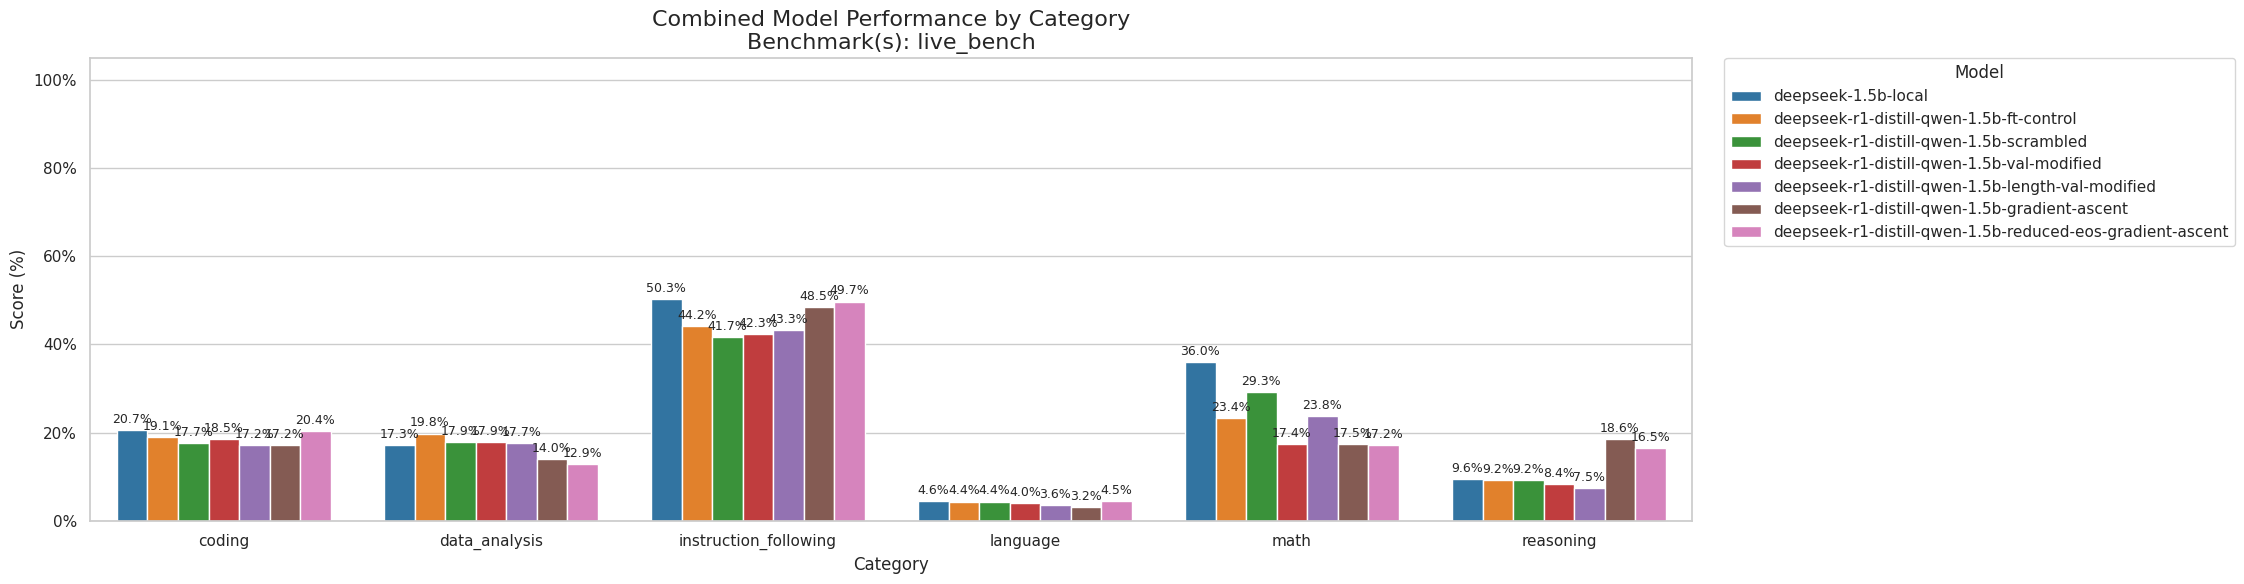

In [ ]:
# Cell 7: Plot Combined Group Scores

visualizer.plot_combined_group_scores()


--- Plotting Combined Task Scores (Excluding: {}) ---
Plotting scores for tasks: ['AMPS_Hard', 'LCB_generation', 'coding_completion', 'connections', 'cta', 'math_comp', 'olympiad', 'paraphrase', 'plot_unscrambling', 'simplify', 'spatial', 'story_generation', 'summarize', 'tablejoin', 'tablereformat', 'typos', 'web_of_lies_v2', 'zebra_puzzle']
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/combined_task_scores_filtered_live_bench.png


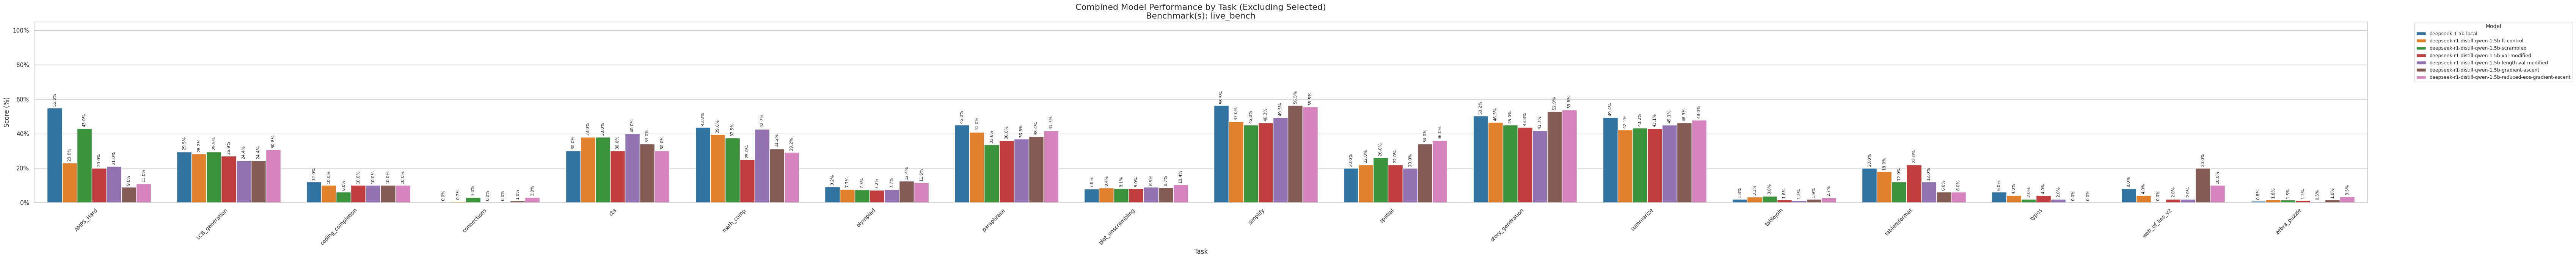

In [ ]:
# Cell 8: Plot Combined Task Scores (Filtered)

visualizer.plot_combined_task_scores()


--- Plotting Separate Model Scores ---

--- Generating plots for model: deepseek-1.5b-local ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-1.5b-local_live_bench.png


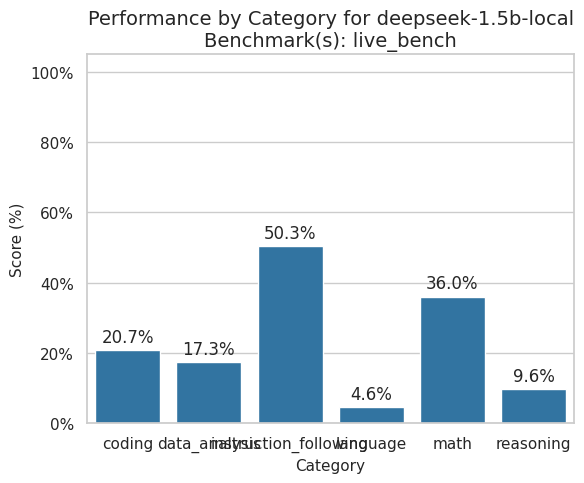

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-1.5b-local_live_bench.png


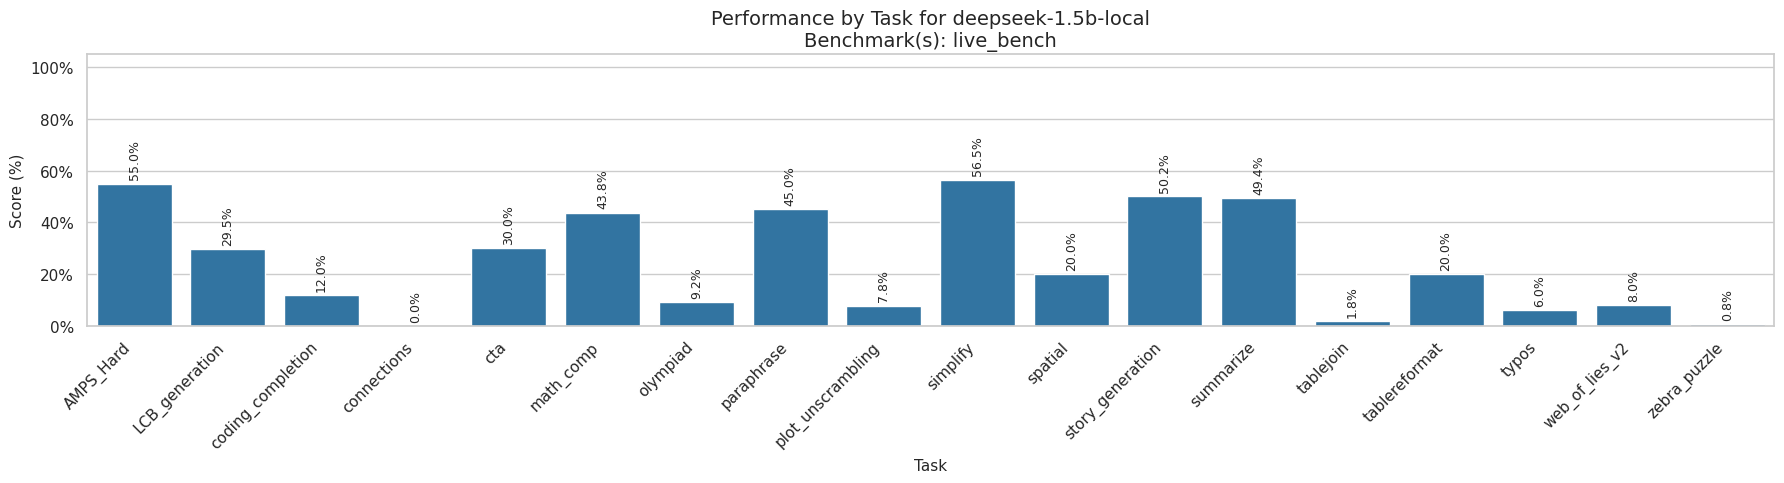


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-ft-control ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-ft-control_live_bench.png


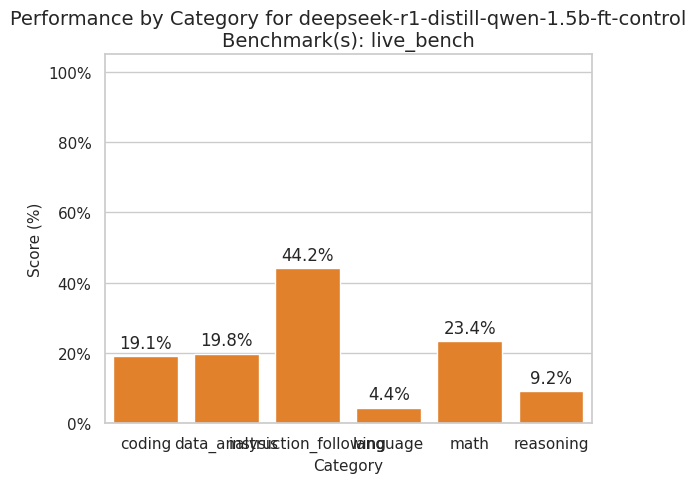

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-ft-control_live_bench.png


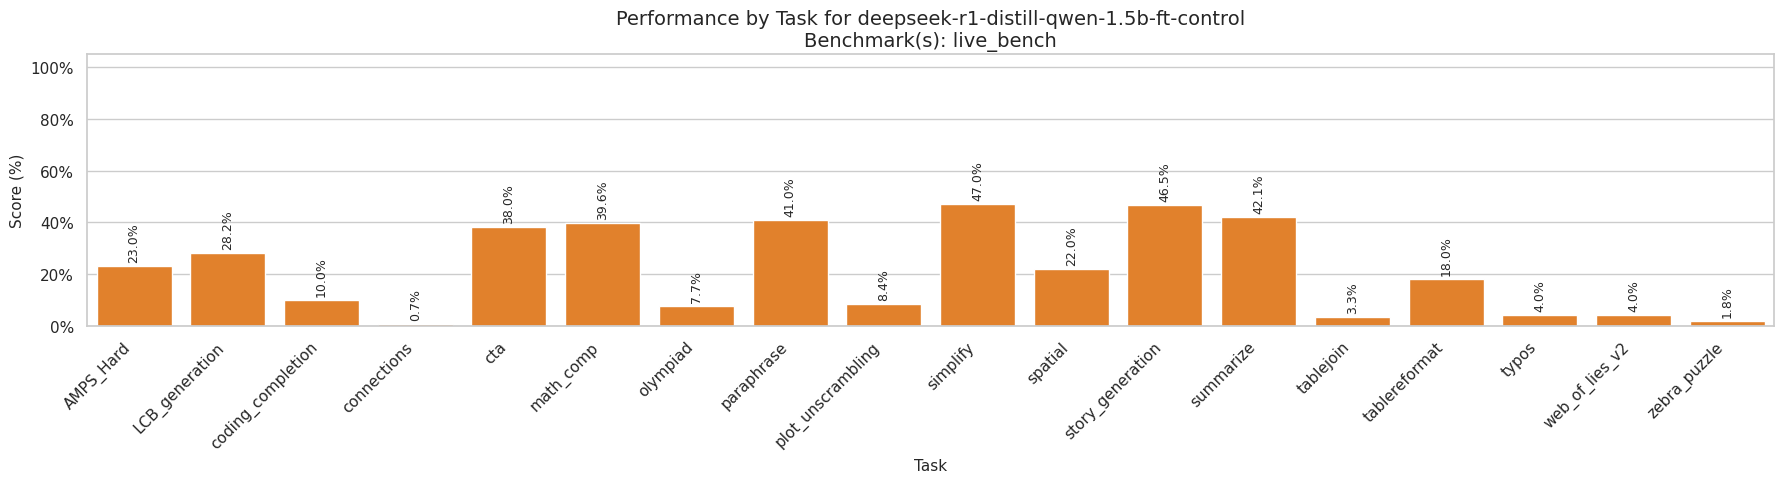


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-scrambled ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-scrambled_live_bench.png


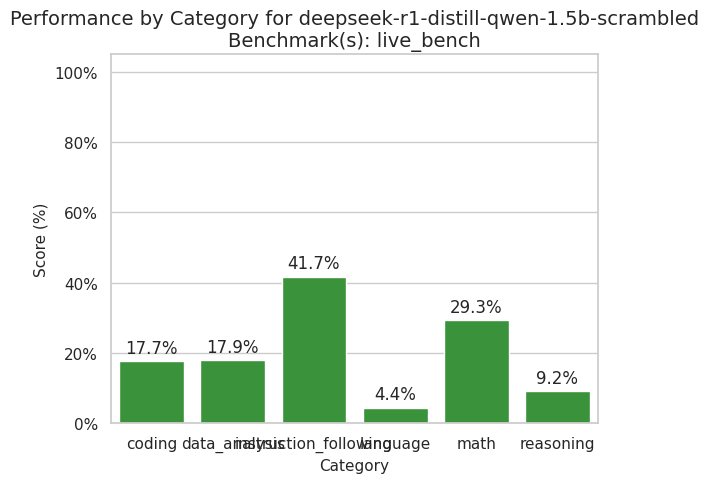

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-scrambled_live_bench.png


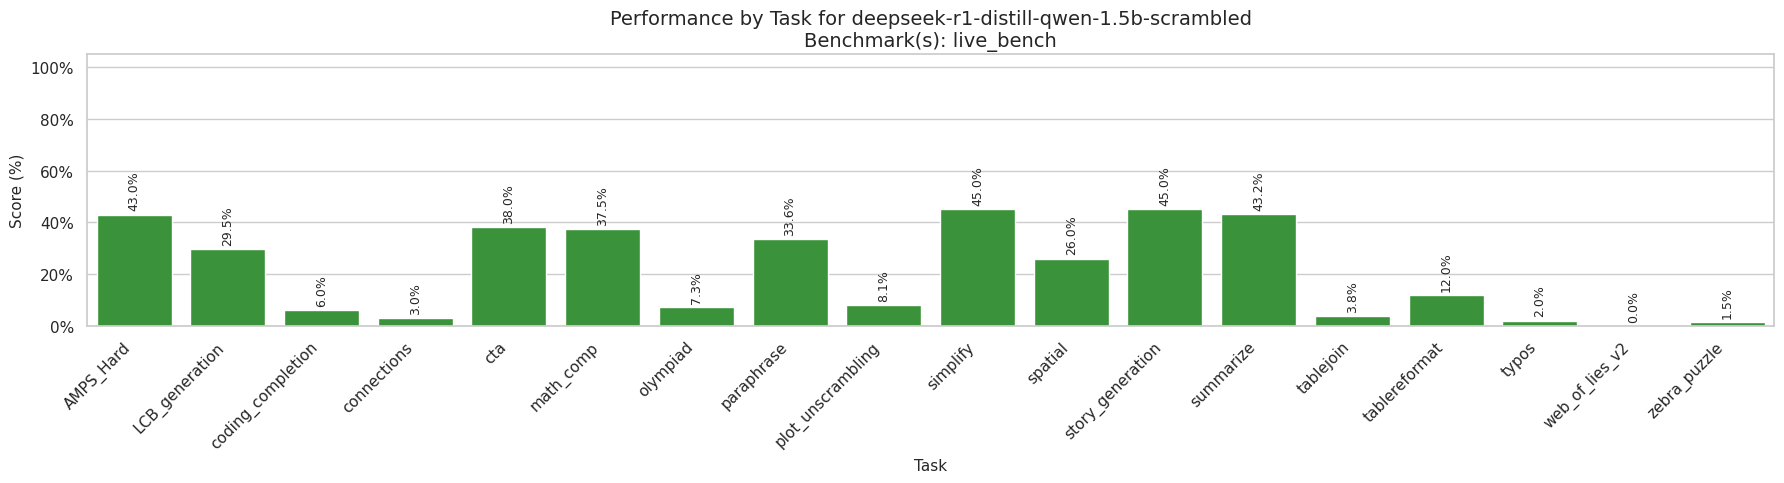


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-val-modified ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-val-modified_live_bench.png


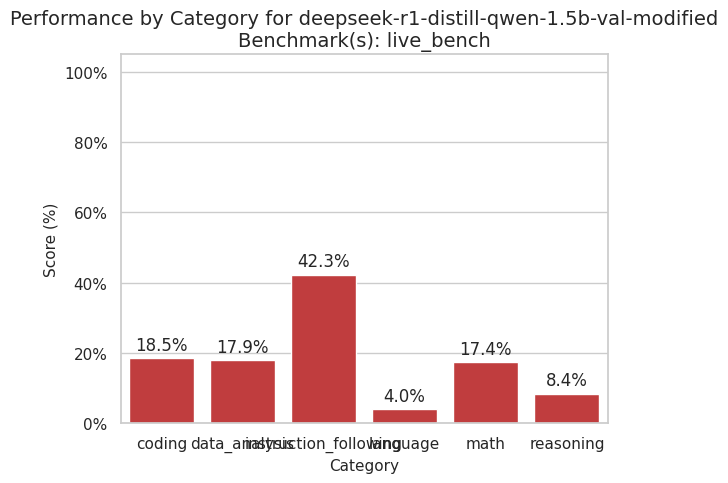

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-val-modified_live_bench.png


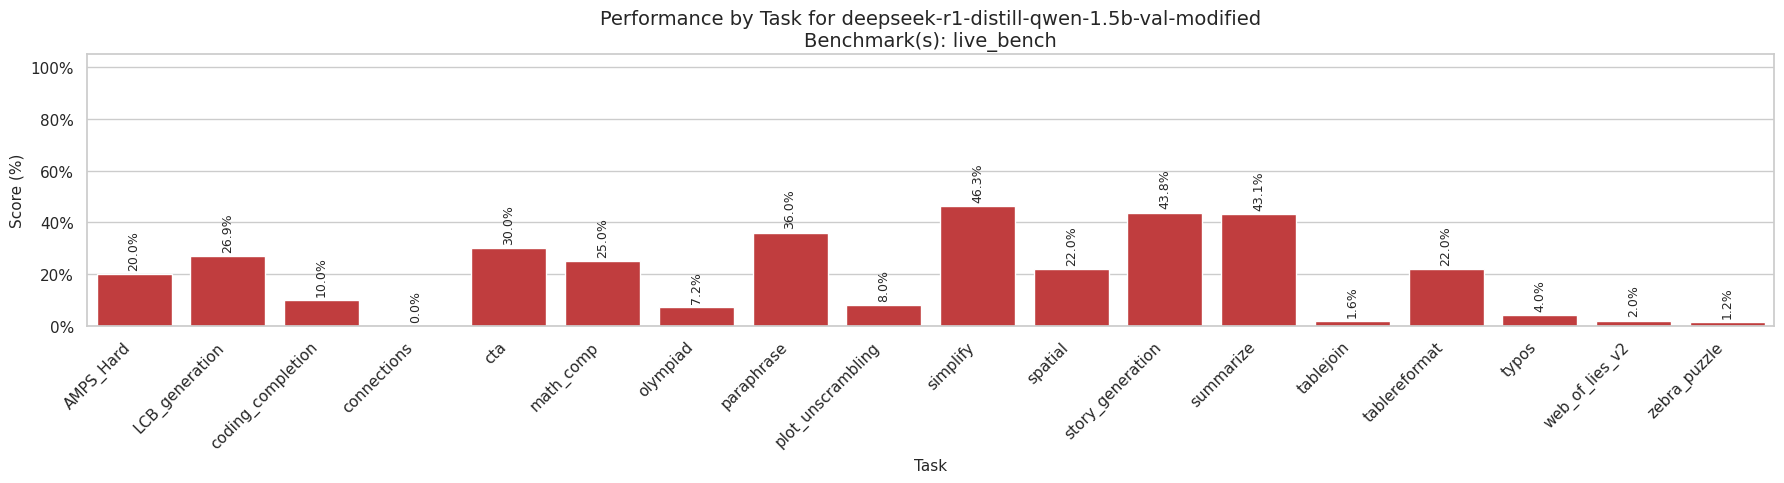


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-length-val-modified ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-length-val-modified_live_bench.png


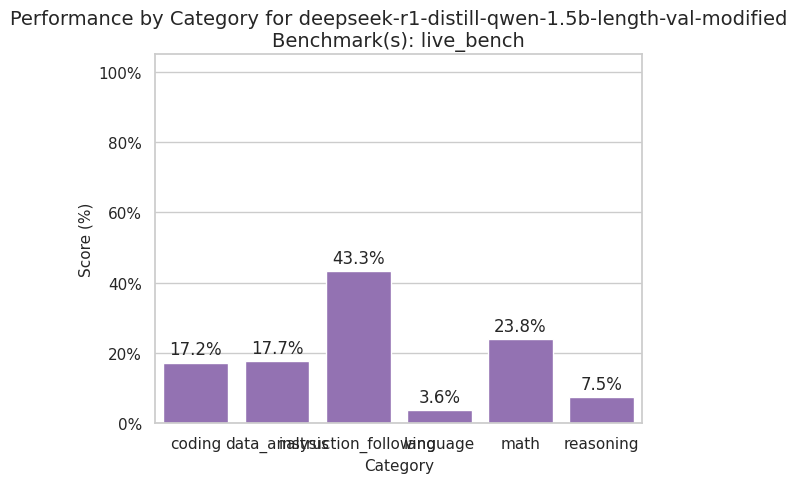

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-length-val-modified_live_bench.png


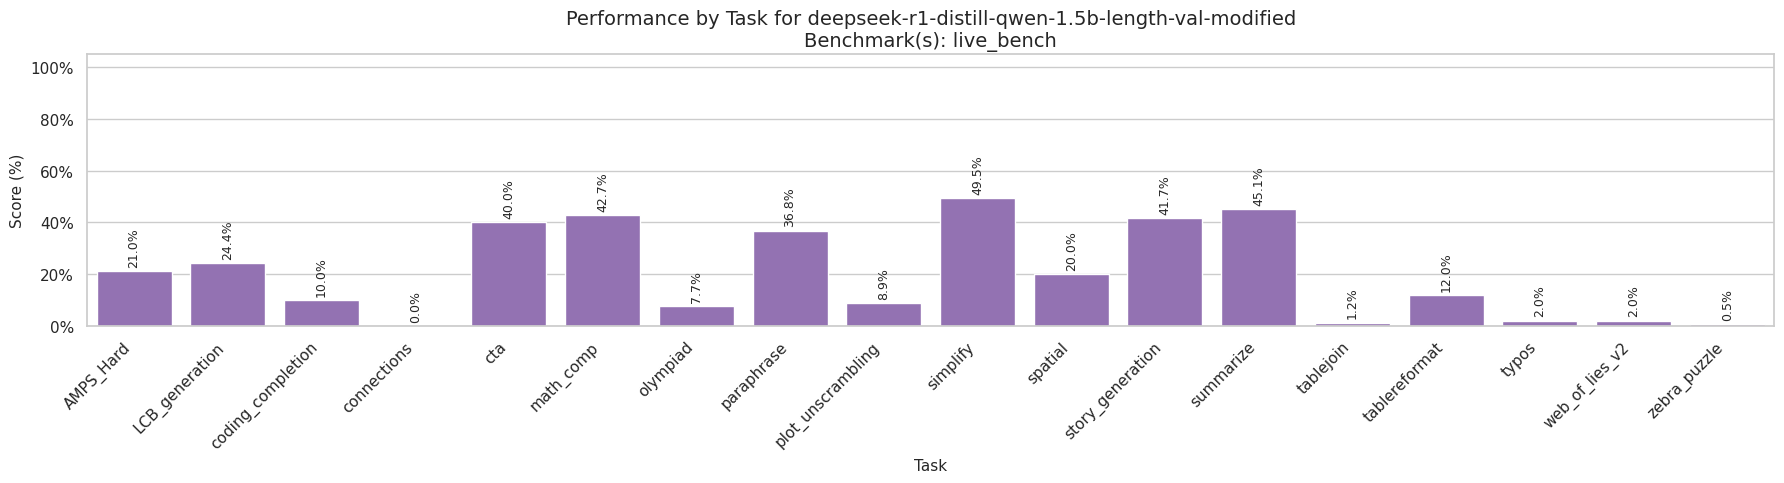


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-gradient-ascent ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-gradient-ascent_live_bench.png


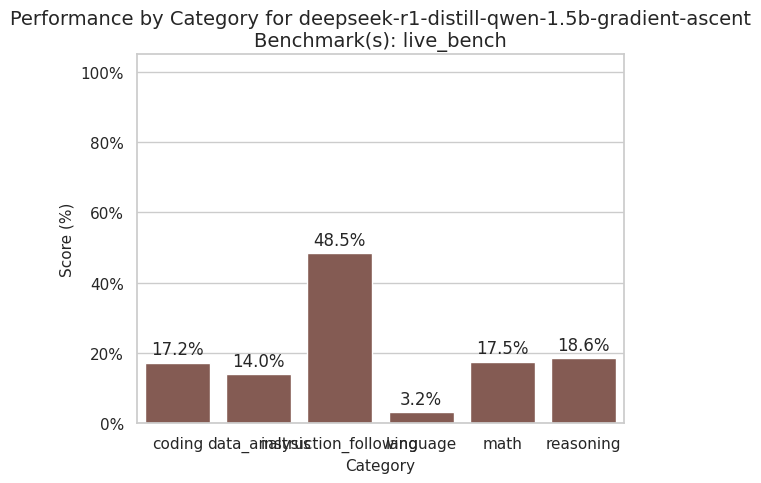

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-gradient-ascent_live_bench.png


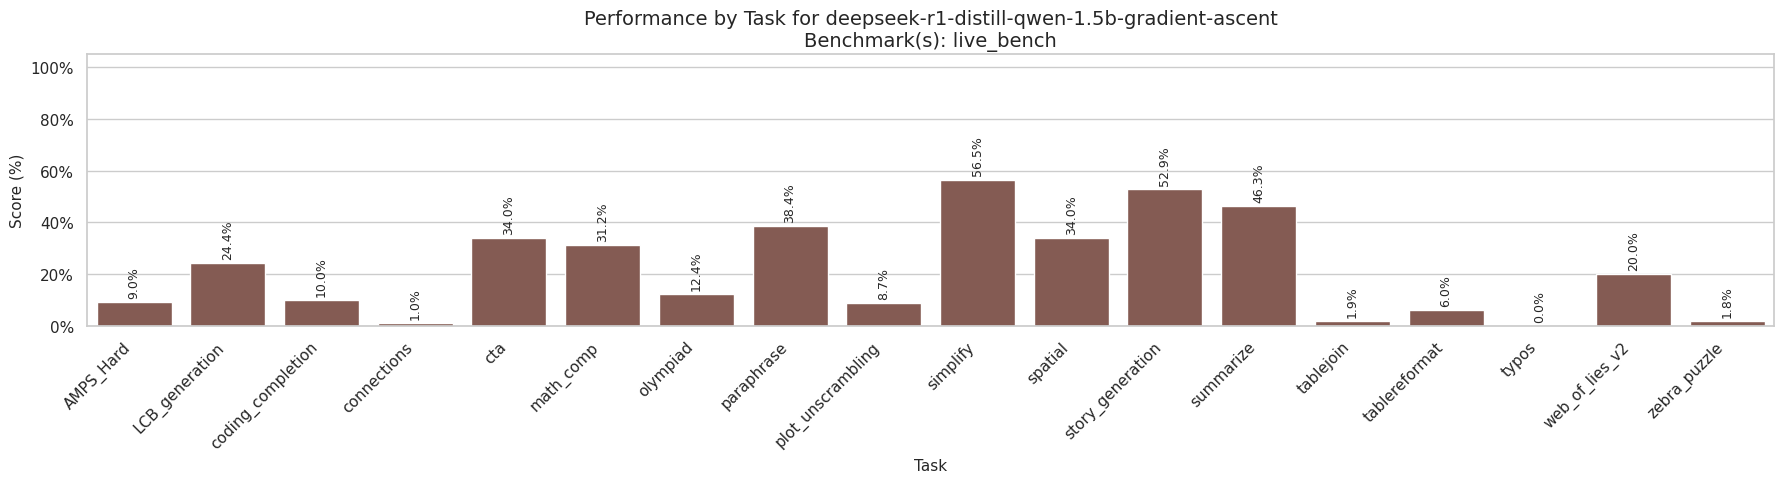


--- Generating plots for model: deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent ---
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_group_scores_deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent_live_bench.png


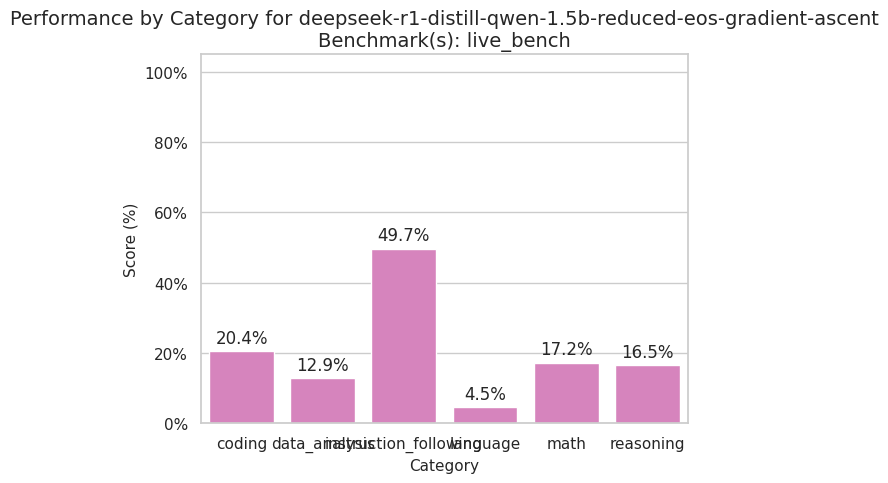

Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/separate_task_scores_deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent_live_bench.png


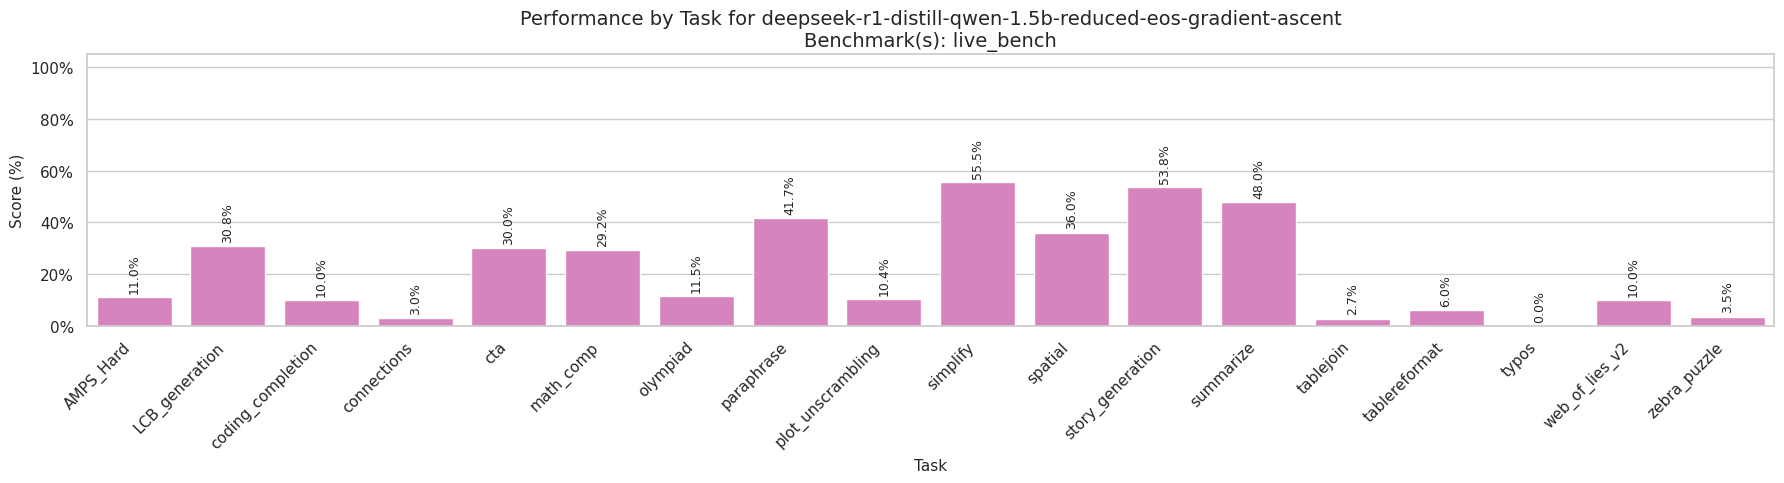

In [ ]:
# Cell 9: Plot Separate Model Scores

visualizer.plot_separate_model_scores()


--- Plotting Token Response Length Statistics by Category ---
Plotting Average Token Length...
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/token_length_average_by_category_live_bench.png


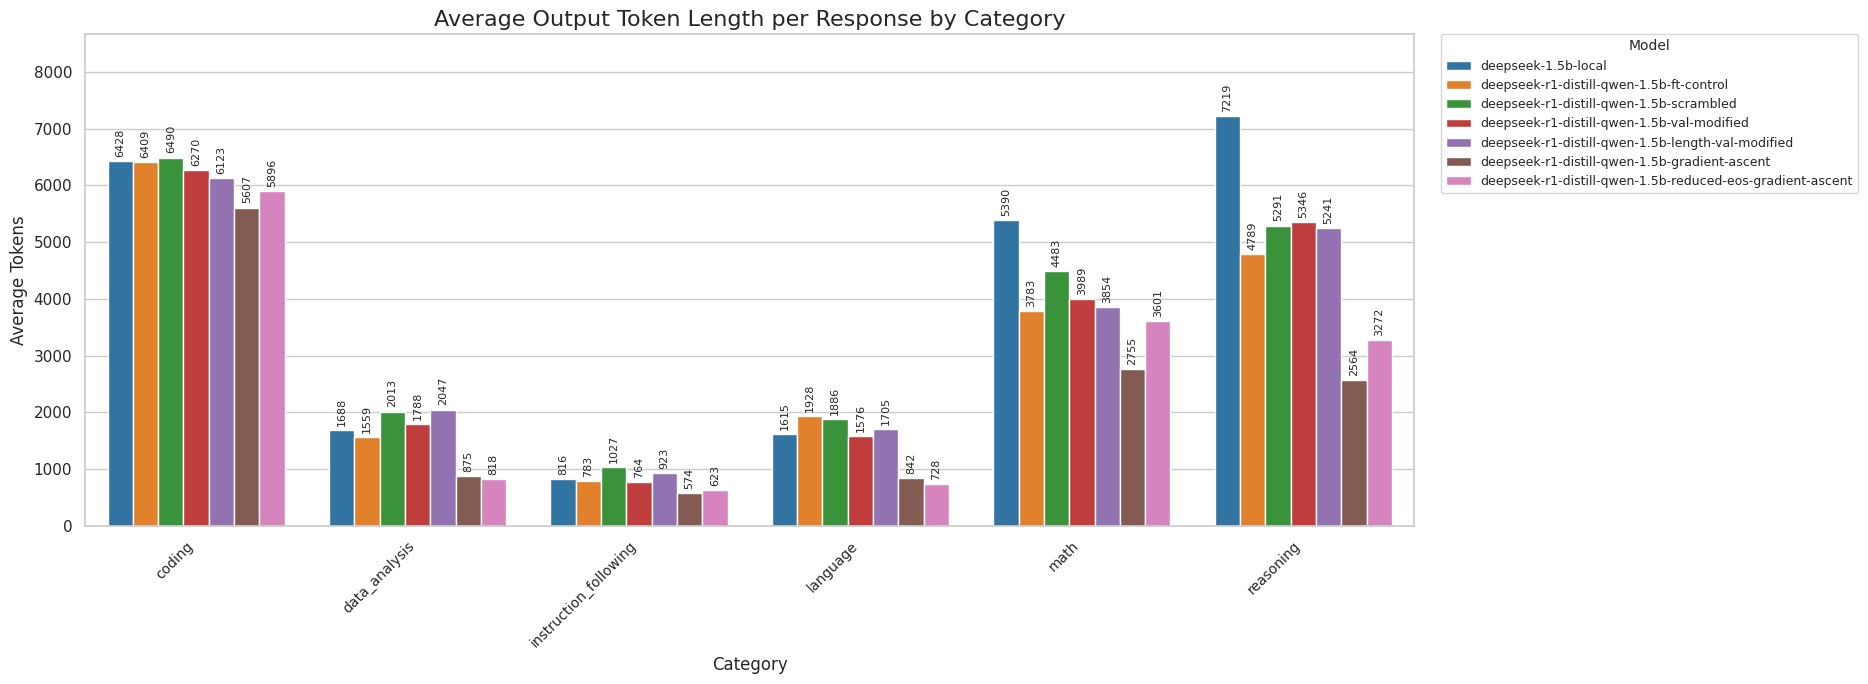

Plotting Median Token Length...
Saving plot to: /content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/plots/token_length_median_by_category_live_bench.png


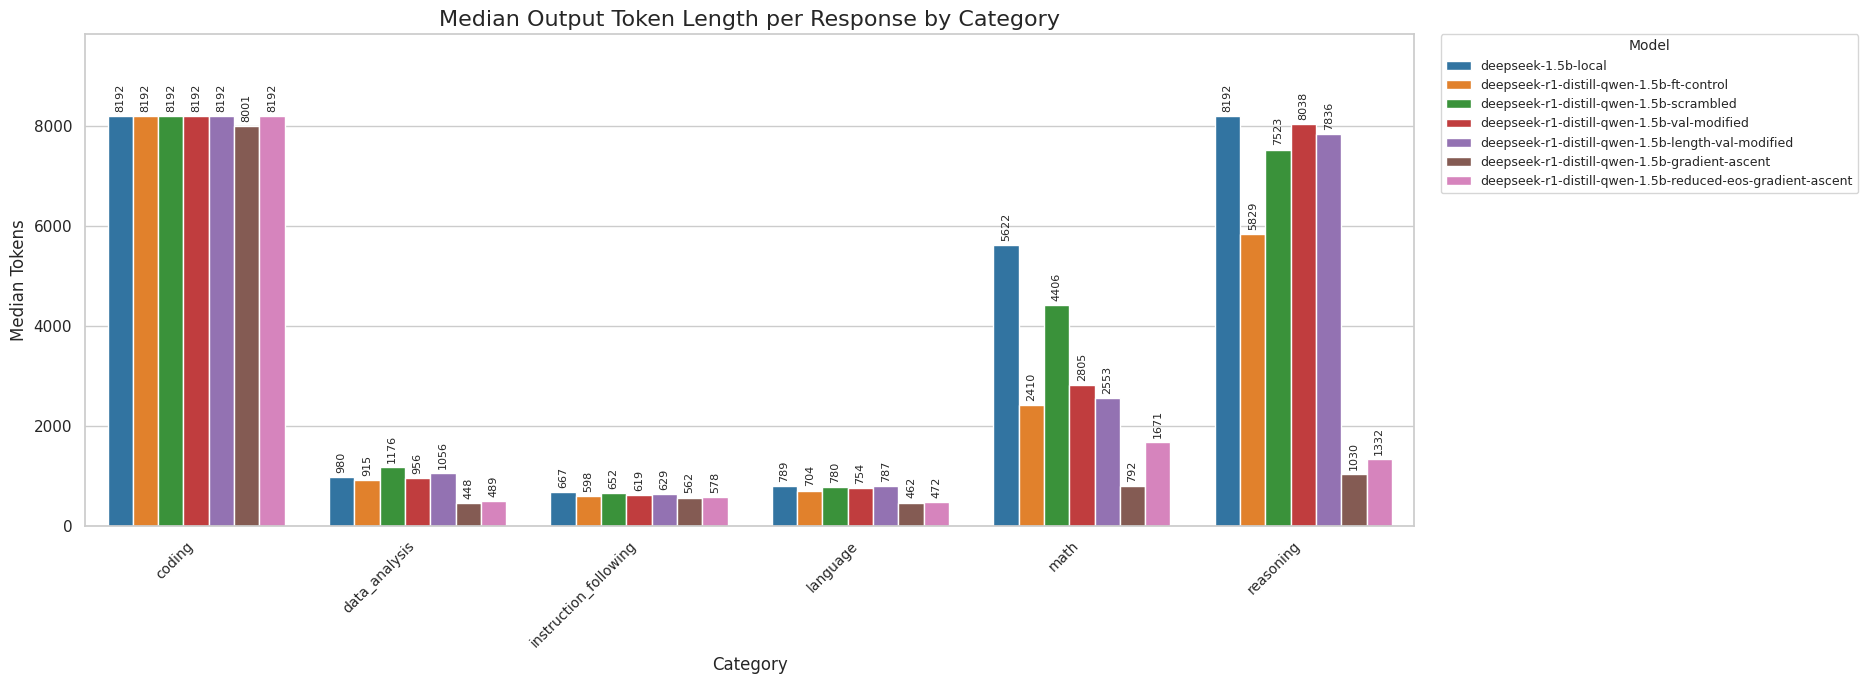

In [ ]:
# Cell 10: Plot Token Length Statistics

visualizer.plot_token_stats()